# Updated Pipeline for joining ERA/MODIS

This notebook is an development on 'legacy' notebooks `3. Pipeline.ipynb`, `8.Updated_Pipeline.ipynb` and `12. Updated_Pipeline_multiple`

See `src/join_MODIS_with_ERA.py` for the script implementation

---


## Pipeline

The general processing pipeline as described in this notebook is as follows:

Pick a datetime, hourly grain e.g. 2018-01-01 T01:00:00

Load the MODIS data for that time from a single file

Load the ERA data for that time from multiple files (sfc_skin, sfc_skin2 etc.) and join to a single dataset.

Perform a nearest neighbours search to find the single closest MODIS entry (Haversine distance) for each ERA grid point, subject to some tolerance. 

Returns sparse hourly data frame for all non-null grid points giving e.g. latitude, longitude, ERA_features, MODIS_targets at a given timestamp


```
  
                                       MODIS       ----> 
datetime: 1st January 2018, 19.00 --->                   df: ERA_features, MODIS_LST as .pkl
                                       ERA {i,j,k} ---->

```
---


## ERA data

We have 4 “types” of ERA file, corresponding to different model fields.

They are:

* sfc_skin_unstructured_...

    aluvp, aluvd, alnip, alnid, cl, cvl, mvh, istl1, istl2, slt, sdfor, z, sd, store, isor, anor, spor, 2d, lsm, fal
    
    10 years

* sfc_skin2_unstructured_...

    ssrd, strd, tp

    10 years, only at 06:00 and 18:00
    
* sfc_unstructured_…

    sp, msl, 10u, 10v, 2t
    
    3 years (2018,2019,2020)
    
* ml_skin_unstructured…

  some spherical harmonic fields
  
  
We will use exclusively `sfc_unstructured_` and `sfc_skin_unstructured_` for 2018-2020

---


Open questions:

* What should this delta be set as? See Appendix.


What should this delta be set as? See Appendix.

# Dictionaries, configs, imports

In [34]:
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import sys
# import cartopy.crs as ccrs
# from scipy.interpolate import griddata
import geopandas as gpd
# #from geopandas import GeoDataFrame
# #from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors
# from datetime import timedelta, date


#These dictionaries describe the local hour of the satellite
local_times = {"aquaDay":"13:30",
               "terraDay":"10:30",
               "terraNight":"22:30",
               "aquaNight":"01:30"
              }
# and are used to load the correct file for dealing with the date-line.
min_hours = {"aquaDay":2,
            "terraDay":-1,
            "aquaNight":-1,
            "terraNight":11}
max_hours = {"aquaDay":24,
            "terraDay":22,
            "aquaNight":13,
            "terraNight":24}


#Path to MODIS data
satellite_folder = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS/'

#Path to ERA data
era_folder = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw'




# Functions

In [188]:
def get_satellite_slice(date : str,
                        utc_hour : int,
                        satellite : str,
                        latitude_bound = None #Recommend only using |lat| < 70 degrees
                        ):
    
    """Function to load hourly slice of MODIS data from Mat Chantry.
       Some naming changes from original, logic mostly unchanged.
       We now drop coordinates that are filtered out"""
    
    #Due to crossing of the datetime, some times will be saved different date
    if utc_hour < min_hours[satellite]:
        file_date = str((np.datetime64(date) - np.timedelta64(1,'D')))
    elif utc_hour > max_hours[satellite]:
        file_date = str((np.datetime64(date) + np.timedelta64(1,'D')))
    else:
        file_date = date
        
    print(file_date)
    # Open .tif 
    #sat_xr = xr.open_rasterio(f'{satellite_folder}/{satellite}_errorGTE03K_04km_{file_date}.tif')
    sat_xr = xr.open_dataarray(f'{satellite_folder}/{satellite}_errorGTE03K_04km_{file_date}.tif',engine="rasterio")

    # Rename spatial dimensions
    sat_xr = sat_xr.rename({'x':'longitude','y':'latitude'})
    
    #Create time delta to change local to UTC
    time_delta = pd.to_timedelta(sat_xr.longitude.data/15,unit='H') 
    
    #Convert local satellite time to UTC and round to nearest hour
    time = (pd.to_datetime([file_date + " " + local_times[satellite]]*time_delta.shape[0]) - time_delta).round('H')
    
    #What date/time does the user want?
    target_time = np.datetime64(f'{date} {utc_hour:02}:00:00')
        
    #Is this target time in this data array?
    time_filter = np.expand_dims(time == target_time,axis=(0,1))
    
    # Make this 1d time filter a 2d mask
    mask = np.logical_and(np.isfinite(sat_xr),time_filter)
    
    # Also filter by latitude
    space_filter = np.expand_dims(np.abs(sat_xr.latitude) < latitude_bound,axis=(0,-1))
    
    #...and add this condition to the mask
    mask = np.logical_and(mask,space_filter)
    
    #Check we have some true values in our mask
    if mask.sum() == 0:
        sys.exit('Exiting - there is no appropriate data')
      
    #Apply mask to data array
    sat_xr_filtered= sat_xr.where(mask,drop=True).load() 
     
    #Close
    sat_xr.close()
    sat_xr = None
    
    
   
    return sat_xr_filtered[0,::-1,:]





def get_era_data(date : str,
                 utc_hour : str,
                 field : str,
                 bounds : dict,
                 source: str):

    """Function to load hourly slice of ERA data 
       Additional filtering by max/min longitude, read from matching MODIS file
    """
        
    #Load the data
    month = '_'.join(date.split('-')[:-1])
    
    if source == 'ERA_skin':
        name = '_skin_'
    if source == 'ERA_sfc':
        name = '_'
        
    utc_0hour = f'{utc_hour:02}'
    fname = f'{era_folder}/{source}/NetCDF/{date}T{utc_0hour}:00:00.000000000.nc'
    ds_era = xr.open_dataset(fname)
    
        
    #Grab correct field
    if field is not None:
        da = ds_era[field]
    else:
        da = ds_era
        
    
     # Also filter by latitude/longtiude
    longitude_filter = (da.longitude > bounds['longitude_min']) & (da.longitude < bounds['longitude_max'])
    latitude_filter =  (da.latitude > bounds['latitude_min']) & (da.latitude < bounds['latitude_max'])
    
  
    da_filtered = da.where(longitude_filter & latitude_filter,drop=True)

    #Explictley close the file
    ds_era.close()
    
    return da_filtered
    



    
def filter_out_sea(ds : xr.Dataset):
    
    """
    Use lsm variable to filter out ocean values, retaining only land values
    Returns a pandas dataframe
    """
    
    df = ds.to_dataframe().reset_index()
    df_land = df.loc[df['lsm'] > 0.5]
    
    
    return df_land
    
    
    

    
    
def find_closest_match_sklearn(MODIS_df : pd.DataFrame, 
                               ERA_df : pd.DataFrame,
                               tolerance : float):
    

    
    #We only want non null MODIS values
    MODIS_df = MODIS_df.dropna()
    
    
    #We dont care about nulls
    #MODIS_df = MODIS_df.dropna()
    #ERA_df = ERA_df.dropna()
    
    
    NN = NearestNeighbors(n_neighbors=1, metric='haversine') #algorithm = balltree, kdtree or brutie force


    NN.fit(np.deg2rad(MODIS_df[['latitude', 'longitude']].values))


    query_lats = ERA_df['latitude'].astype(np.float64)
    query_lons = ERA_df['longitude'].astype(np.float64)
    X = np.deg2rad(np.c_[query_lats, query_lons])
    distances, indices = NN.kneighbors(X, return_distance=True)


    r_km = 6371 # multiplier to convert to km (from unit distance)
    distances = distances*r_km


    
    df_combined = ERA_df.reset_index().join(MODIS_df.iloc[indices.flatten()].reset_index(), lsuffix='_ERA',rsuffix='_MODIS')
    df_combined['distance'] = distances
    df_combined['MODIS_idx'] = indices

    #Filter and surface selected columns
    df_combined_matches = df_combined.query('distance < %.9f' % tolerance)

    
    
    return df_combined_matches.dropna().reset_index()   
    #return df_combined.reset_index()
    
    


def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)
        
        
        
        

def plot_map(ds,x,y,q): #slow plotting function

    #Takes a ds, converts to pandas df
    
    if isinstance(ds, pd.DataFrame):
        df = ds
    else:
        df = ds.to_dataframe().reset_index()#.dropna()
        
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]))
    
    #Plot the world
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world.boundary.plot(figsize=(24,12))
    
    gdf.plot(ax=ax,column=q,cmap='plasma',markersize=1,legend=True)
    
    plt.show()
    


In [39]:
#Set the parameters
date = '2018-04-19'
utc_hour = 11

# Getting the MODIS data

This uses the `get_satellite_slice` function from Mat Chantry. Some nomencature changes from the original and we also drop coordinates to get only non null values.

Example:

In [119]:
%%time
MODIS = get_satellite_slice(date=date,utc_hour=utc_hour,satellite='aquaDay',latitude_bound=70)

2018-04-19
CPU times: user 1.03 s, sys: 149 ms, total: 1.18 s
Wall time: 1.45 s


In [127]:
#It will be useful to have a pandas version
MODIS_df = MODIS.to_dataframe(name='MODIS_LST').reset_index()

# Getting the ERA data

This uses the `get_era_data` function, again from MC. Some additional changes to filter by the spatial bounds provided by our MODIS data slice. We use `delta` to get an ERA box that **encloses** the MODIS box. 

Example:

In [196]:
%%time
delta = 1.0
bounds = {"latitude_min" :MODIS.latitude.data.min()-delta,
          "latitude_max" :MODIS.latitude.data.max()+delta,
          "longitude_min":MODIS.longitude.data.min()-delta,
          "longitude_max":MODIS.longitude.data.max()+delta
          }
fields = None #['t2m','v10'] #'None' selects all data variables. Selecting > 1 field returns a dataset rather than a data array
ERA_sfc = get_era_data(date = date,utc_hour=utc_hour,field=fields,bounds=bounds,source='ERA_sfc')
ERA_skin = get_era_data(date = date,utc_hour=utc_hour,field=fields,bounds=bounds,source='ERA_skin')

CPU times: user 95.6 ms, sys: 0 ns, total: 95.6 ms
Wall time: 154 ms


# Plotting selected MODIS / ERA snapshots and filtering by land

We have a slice of MODIS data (`MODIS`) at a particular time (hourly grain) and a corresponding slice of ERA data (`ERA`).

As a sanity check, lets combine these two datasets and have a quick look at what these data slices look like:

In [197]:
ERA = xr.merge([ERA_sfc, ERA_skin])

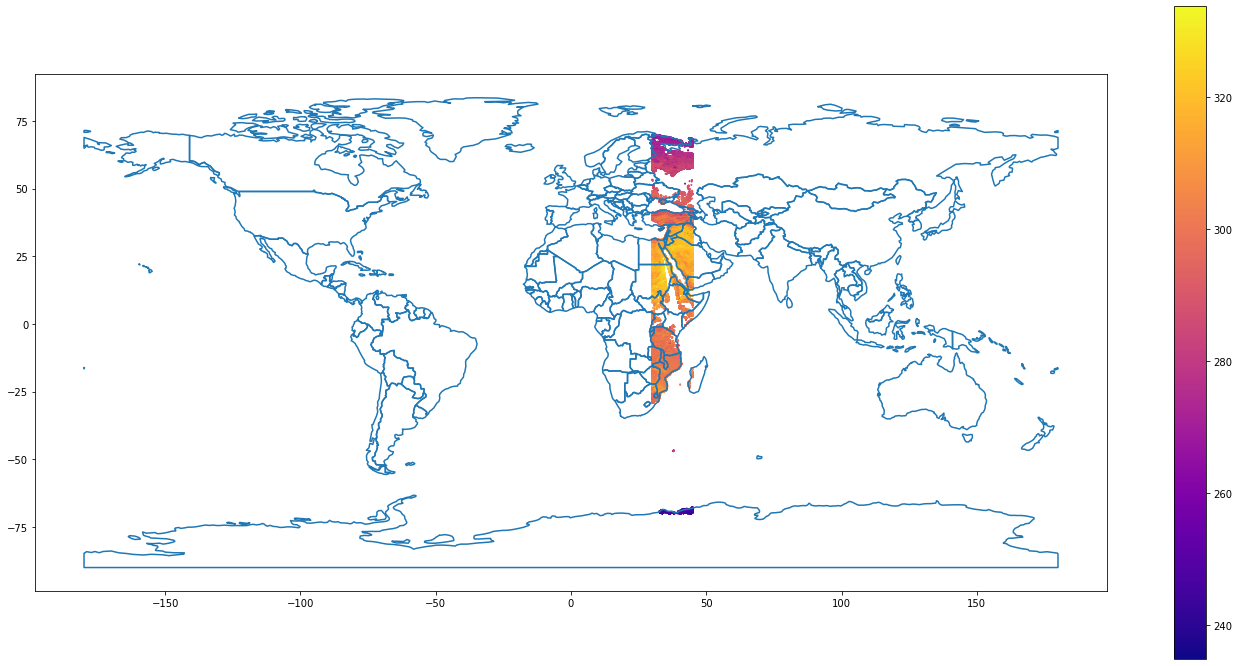

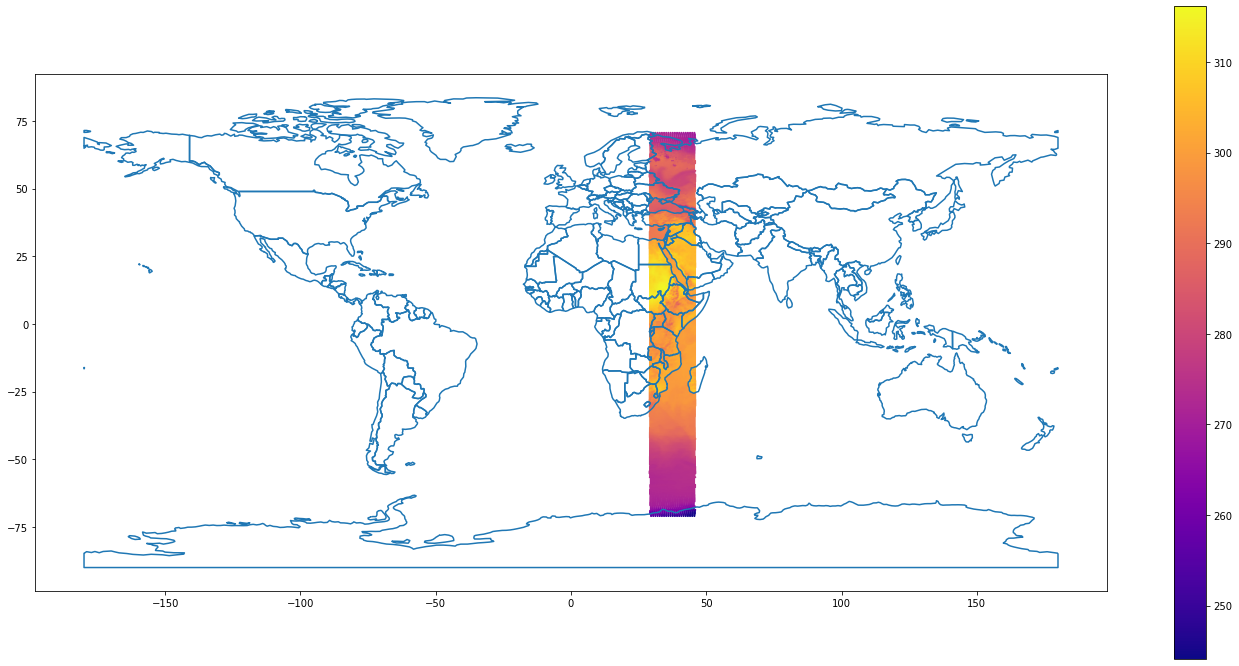

In [198]:
plot_map(MODIS,'longitude','latitude','band_data')
plot_map(ERA,'longitude','latitude','t2m')

We can see that MODIS data is over land but we have ERA data over land and sea.

We can get just the land data by using the land sea mask `lsm` parameter https://apps.ecmwf.int/codes/grib/param-db?id=172

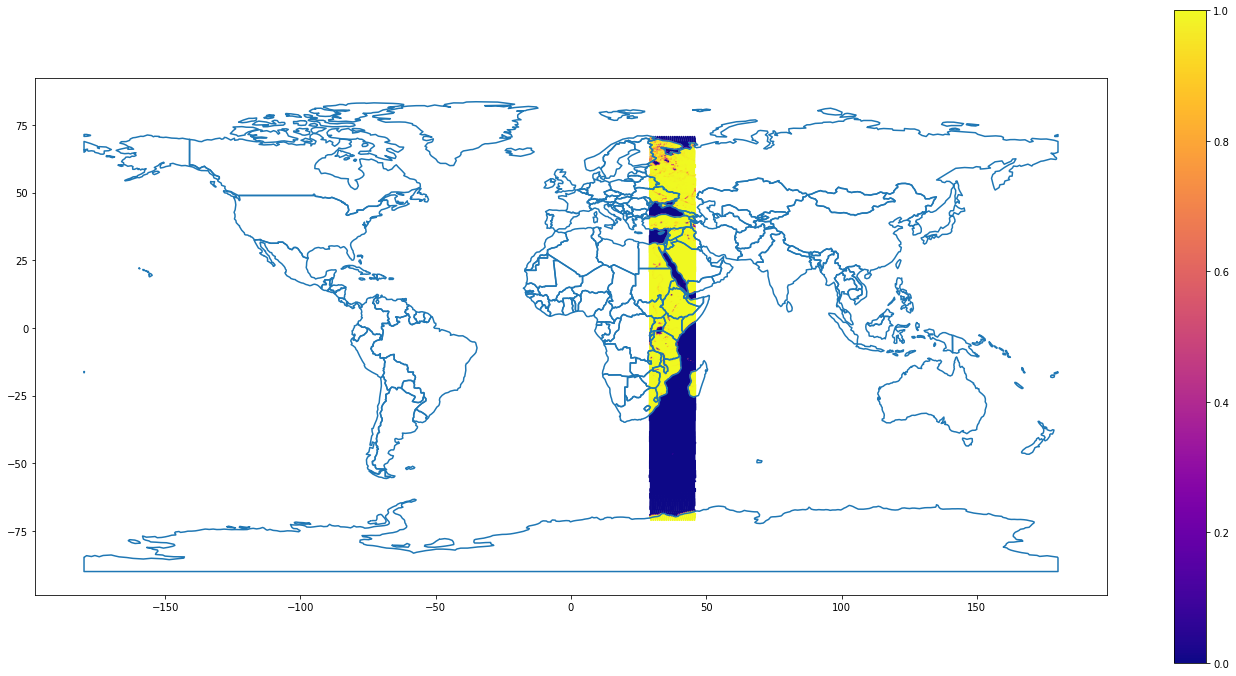

In [199]:
plot_map(ERA,'longitude','latitude','lsm')

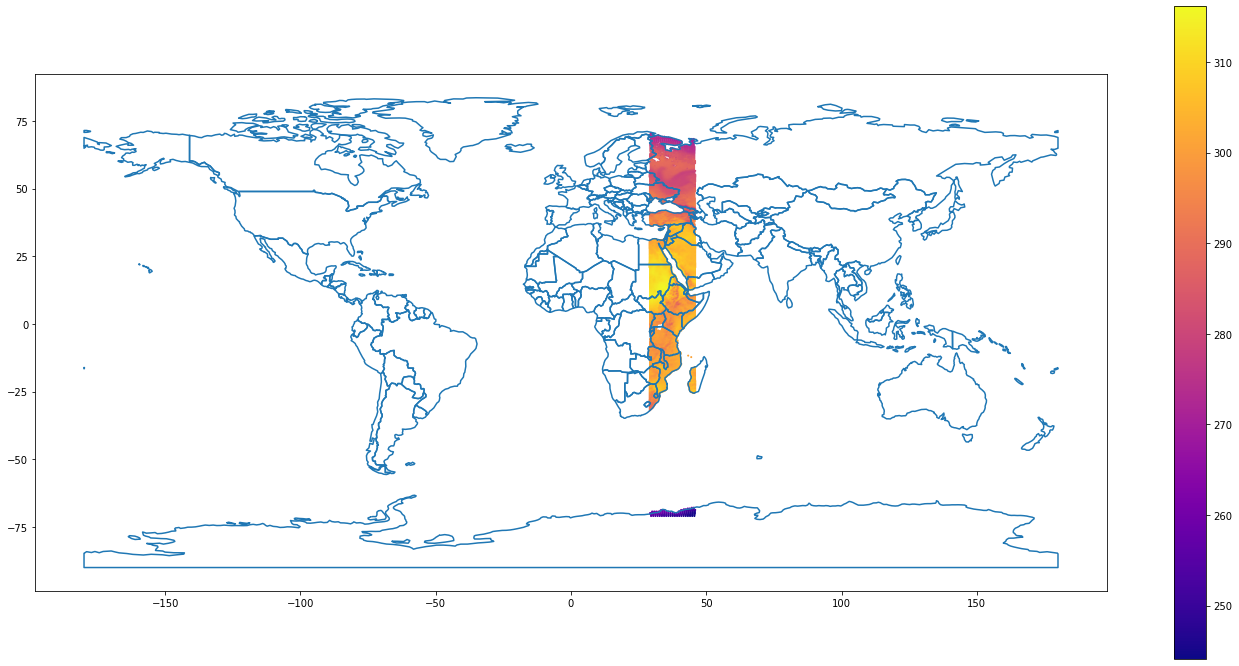

In [200]:
ERA_df_land = filter_out_sea(ERA)
plot_map(ERA_df_land,'longitude','latitude','t2m')

# Finding a match


By virtue of the time slices we have performed, the data is already matched in time.

We now need to match in space. i.e. for each gridpoint in ERA we want to find the closest match in MODIS. We use the Haversine distance as our closeness metric.

We also need to enforce a tolerance to filter out matches which are not sufficently close.

This process returns a pandas df of the ERA data joined with the matching rows in MODIS. This provides a corresponding MODIS temperature for each entry (where available) in ERA. We also return the Haversine distance between the matches. Perhaps this could be used as some kind of error... 

Example:

In [201]:
%%time
df_sk = find_closest_match_sklearn(MODIS_df,
                                   ERA_df_land,
                                   tolerance=50) #tolerance is in units of km 

CPU times: user 2.78 s, sys: 3.43 ms, total: 2.78 s
Wall time: 2.78 s


MODIS data:


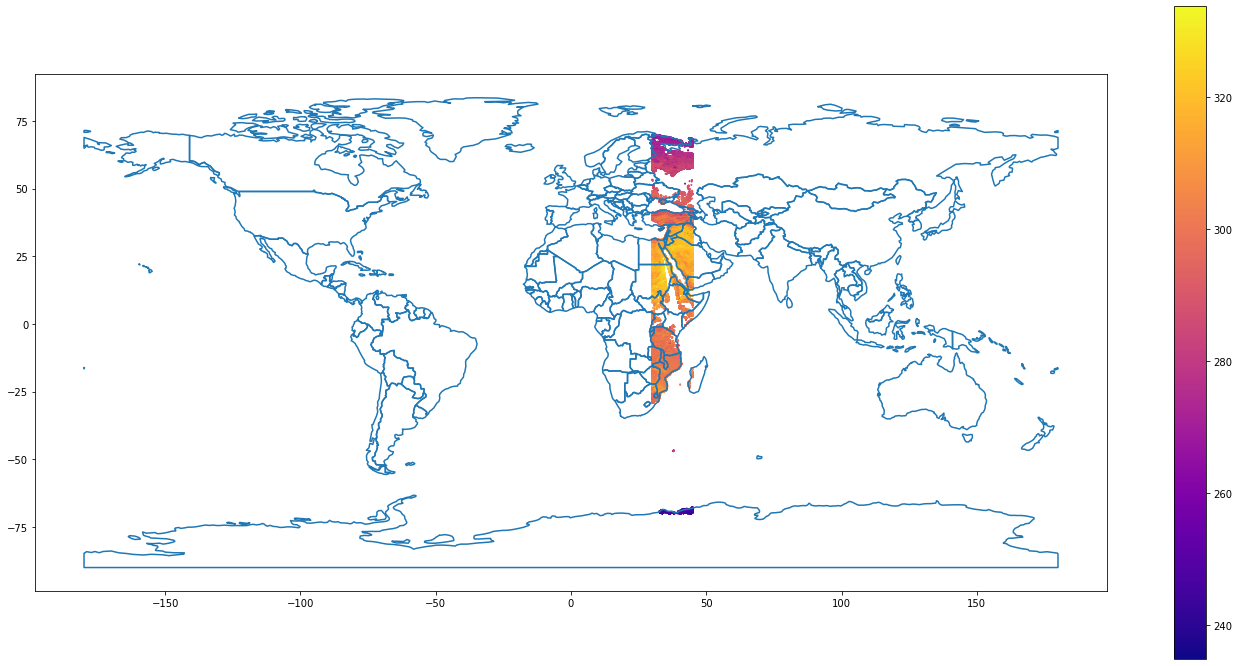

ERA land data:


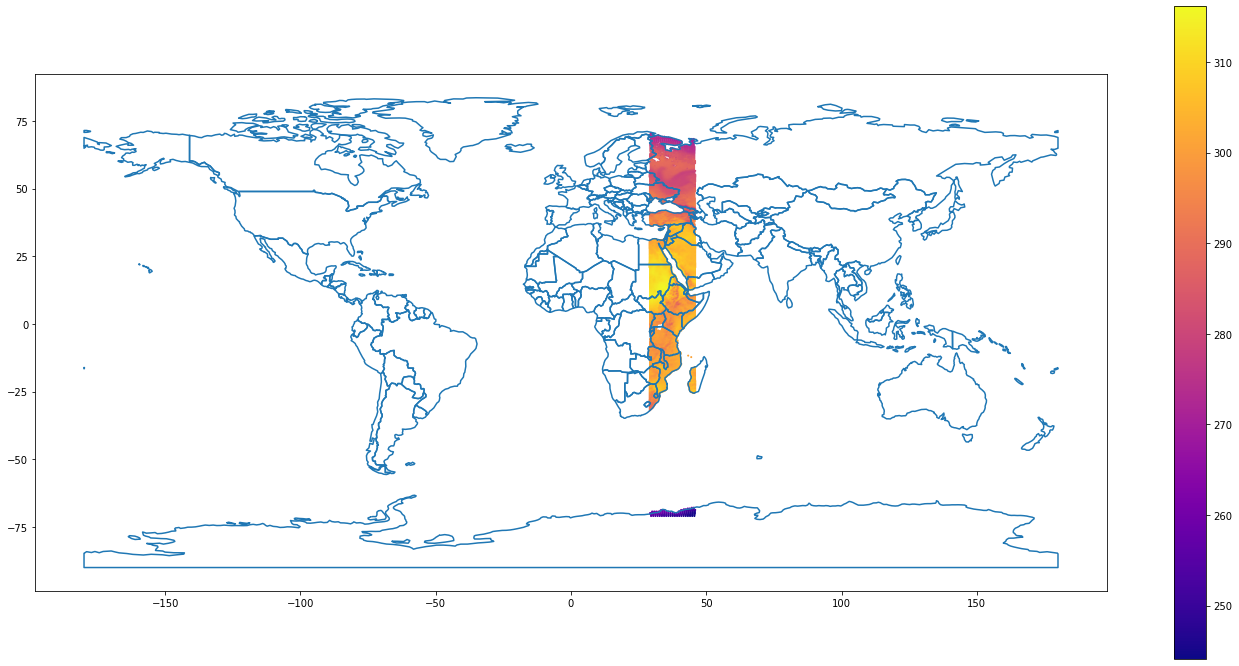

Matched values:


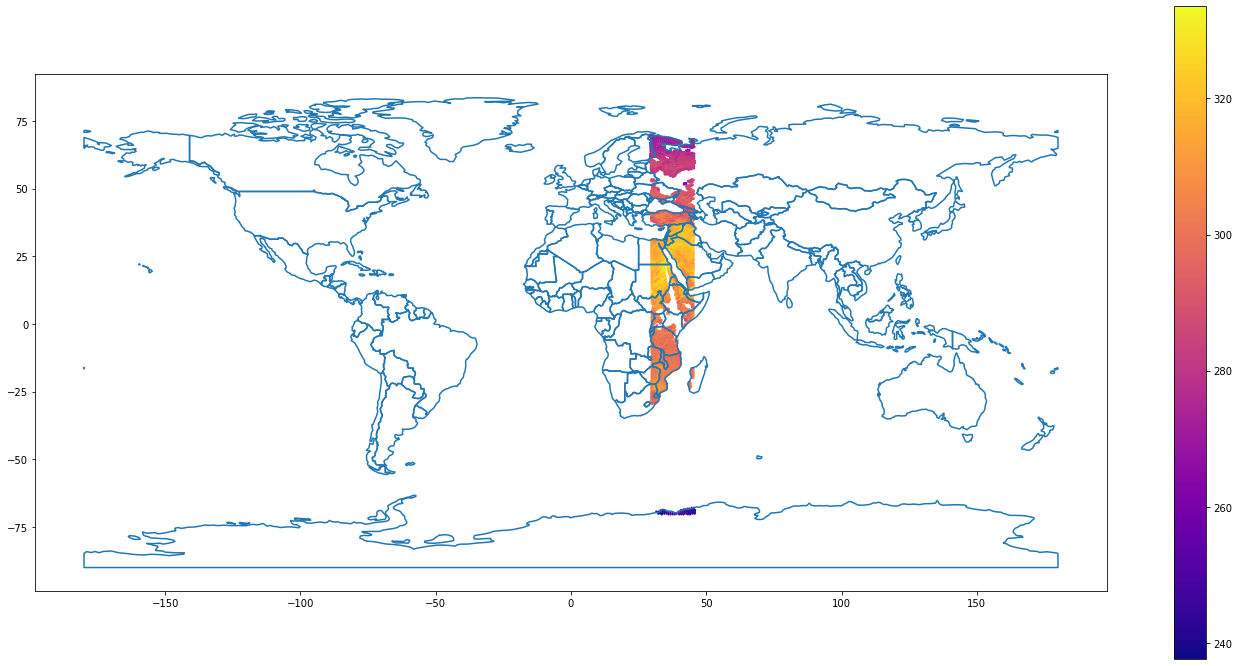

Matched value distances:


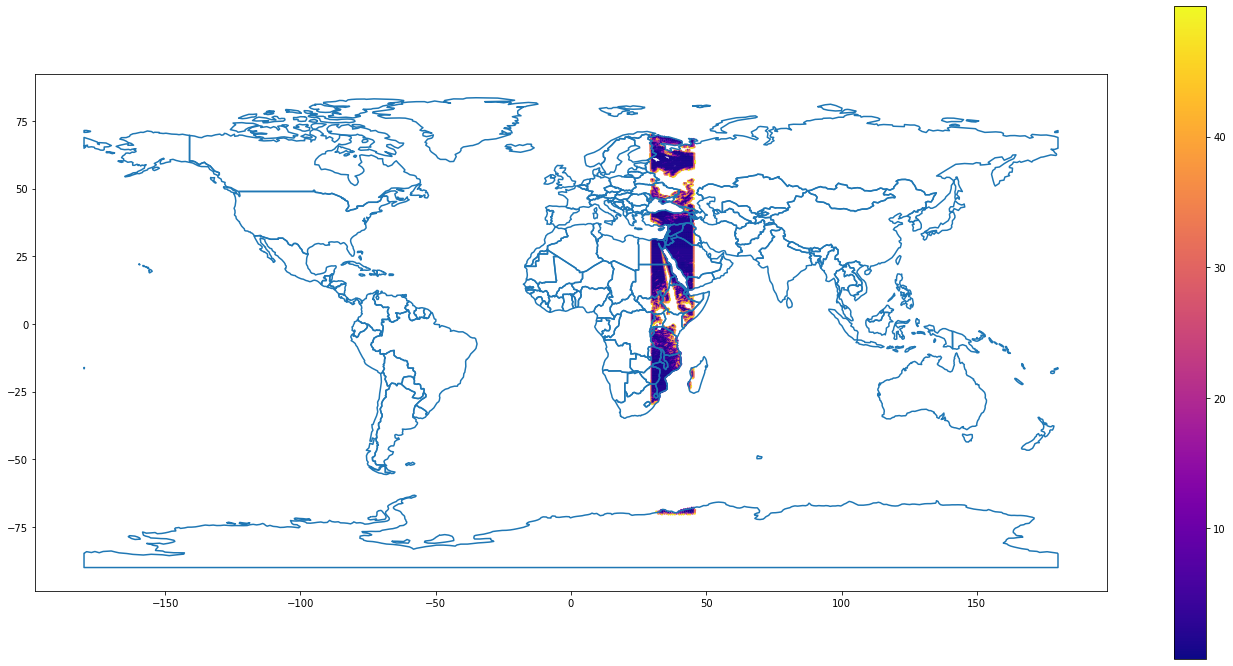

13781 10231


In [202]:
print ('MODIS data:')
plot_map(MODIS_df,'longitude','latitude','MODIS_LST')
print ('ERA land data:')
plot_map(ERA_df_land,'longitude','latitude','t2m')
print ('Matched values:')
plot_map(df_sk,'longitude_ERA','latitude_ERA','MODIS_LST')
print ('Matched value distances:')
plot_map(df_sk,'longitude_ERA','latitude_ERA','distance')
print (len(ERA_df_land), len(df_sk))


Matched values, tolerance: 10  km


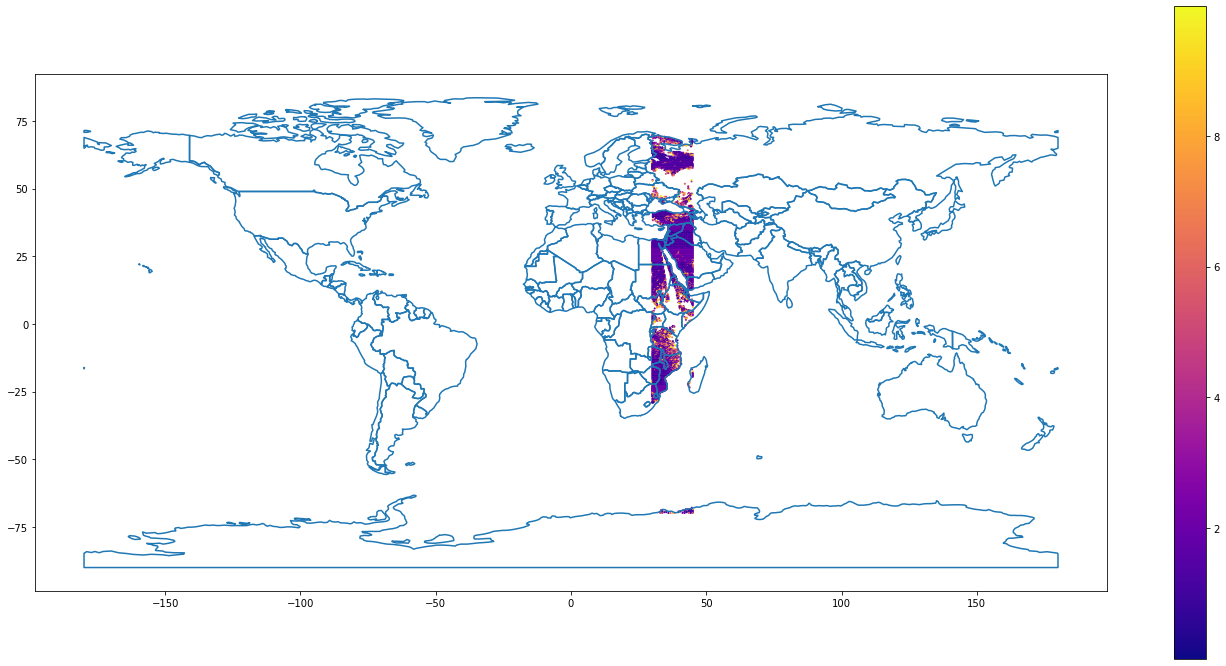

In [203]:
tol = 10
df_sk_filtered = df_sk.query('distance < %.9f' % tol)
print ('Matched values, tolerance:', tol, ' km')
plot_map(df_sk_filtered,'longitude_ERA','latitude_ERA','distance')



---

# Appendix

All of the above example was just for a single time snapshot.

Lets combine this into a single pipeline:

In [74]:
def pipeline(date,utc_hour,satellite,latitude_bound,ERA_fields,tolerance):

    # MODIS data
    MODIS = get_satellite_slice(date,utc_hour,satellite,latitude_bound)
    
    print ('MODIS DATA = ')
    display(MODIS.to_dataframe())
    for i in range(3):
        print('----------------------------------')

    #ERA data
    
    delta = 10
    bounds = {"latitude_min" :MODIS.latitude.data.min()-delta,
          "latitude_max" :MODIS.latitude.data.max()+delta,
          "longitude_min":MODIS.longitude.data.min()-delta,
          "longitude_max":MODIS.longitude.data.max()+delta
          }

    
    
    ERA_sfc = get_era_data(date, utc_hour, field=ERA_fields,bounds=bounds,source='ERA_sfc')
    ERA_skin = get_era_data(date, utc_hour, field=ERA_fields,bounds=bounds,source='ERA_skin')
    ERA = xr.merge([ERA_sfc, ERA_skin])
    
    
    print ('ERA DATA =')
    display(ERA.to_dataframe())
    for i in range(3):
        print('----------------------------------')


    
    #Combine
    print('Start combo')
    df_sk = find_closest_match_sklearn(MODIS,ERA,tolerance)
    
    display(df_sk)
    
    return df_sk

In [75]:
%%time

date = '2018-02-01'
utc_hour=8
satellite='aquaDay'
latitude_bound=70
ERA_fields = None #['t2m','v10'] #'None' selects all available data variables. 
tolerance = 10 #km


df = pipeline(date,utc_hour,satellite,latitude_bound,ERA_fields,tolerance)


2018-02-01
MODIS DATA = 


band  spatial_ref   band_data
latitude  longitude                                
69.983333 -23.750000     1            0  235.199997
          -23.716667     1            0  235.269226
          -23.683333     1            0  235.509995
          -23.650000     1            0  235.559998

----------------------------------
----------------------------------
----------------------------------
ERA DATA =


,sp,msl,u10,v10,t2m,latitude,longitude,number,time,step,...,sdfor,z,sd,sdor,isor,anor,slor,d2m,lsm,fal
values,,,,,,,,,,,,,,,,,,,,,
0,103165.453125,103173.50,0.017487,-2.873947,246.714844,89.784877,0.0,0,2018-02-01 15:00:00,0 days,...,0.000000,5.503662,0.0,0.000000,0.000000,0.785398,0.000100,243.889557,0.0,0.765621
1,103157.453125,103167.25,-0.888763,-2.762619,246.962891,89.784877,20.0,0,2018-02-01 15:00:00,0 days,...,0.000000,6.609131,0.0,0.000000,0.000000,0.785398,0.000100,244.157135,0.0,0.765621
2,103154.453125,103162.00,-1.753998,-2.431564,247.181641,89.784877,40.0,0,2018-02-01 15:00:00,0 days,...,0.000000,5.077881,0.0,0.000000,0.000000,0.785398,0.000100,244.391510,0.0,0.765621
3,103153.453125,103158.25,-2.498138,-1.814377,247.304688,89.784877,60.0,0,2018-02-01 15:00:00,0 days,...,0.000000,2.906006,0.0,0.000000,0.000000,0.785398,0.000100,244.516510,0.0,0.765621
4,103154.453125,103156.25,-2.988373,-0.939377,247.509766,89.784877,80.0,0,2018-02-01 15:00:00,0 days,...,0.000000,1.370850,0.0,0.000000,0.000000,0.785398,0.000100,244.756744,0.0,0.765621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542075,69429.453125,100773.25,0.199127,2.869217,237.253906,-89.784877,-100.0,0,2018-02-01 15:00:00,0 days,...,0.830017,27070.917969,10.0,2.146240,0.068906,-0.123501,0.002210,233.276276,1.0,0.850002
542076,69494.453125,100782.75,-0.966888,2.738358,237.353516,-89.784877,-80.0,0,2018-02-01 15:00:00,0 days,...,0.781799,27001.785156,10.0,3.880493,0.101069,-0.203273,0.001679,233.354401,1.0,0.850002
542077,69521.453125,100786.75,-2.057709,2.153397,237.425781,-89.784877,-60.0,0,2018-02-01 15:00:00,0 days,...,0.576355,26972.625000,10.0,5.408325,0.417360,-0.395258,0.000831,233.405182,1.0,0.850002


----------------------------------
----------------------------------
----------------------------------
Start combo


,index,index_ERA,values,sp,msl,u10,v10,t2m,latitude_ERA,longitude_ERA,...,lsm,fal,index_MODIS,latitude_MODIS,longitude_MODIS,band,spatial_ref,MODIS_LST,distance,MODIS_idx
0,0,0,0,103165.453125,103173.50,0.017487,-2.873947,246.714844,89.784877,0.0,...,0.0,0.765621,3,69.983333,-23.65,1,0,235.559998,2203.860238,3
1,1,1,1,103157.453125,103167.25,-0.888763,-2.762619,246.962891,89.784877,20.0,...,0.0,0.765621,3,69.983333,-23.65,1,0,235.559998,2208.502751,3
2,2,2,2,103154.453125,103162.00,-1.753998,-2.431564,247.181641,89.784877,40.0,...,0.0,0.765621,3,69.983333,-23.65,1,0,235.559998,2215.234000,3
3,3,3,3,103153.453125,103158.25,-2.498138,-1.814377,247.304688,89.784877,60.0,...,0.0,0.765621,3,69.983333,-23.65,1,0,235.559998,2223.228025,3
4,4,4,4,103154.453125,103156.25,-2.988373,-0.939377,247.509766,89.784877,80.0,...,0.0,0.765621,3,69.983333,-23.65,1,0,235.559998,2231.512913,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542075,542075,542075,542075,69429.453125,100773.25,0.199127,2.869217,237.253906,-89.784877,-100.0,...,1.0,0.850002,0,69.983333,-23.75,1,0,235.199997,17783.533423,0
542076,542076,542076,542076,69494.453125,100782.75,-0.966888,2.738358,237.353516,-89.784877,-80.0,...,1.0,0.850002,0,69.983333,-23.75,1,0,235.199997,17775.960731,0
542077,542077,542077,542077,69521.453125,100786.75,-2.057709,2.153397,237.425781,-89.784877,-60.0,...,1.0,0.850002,0,69.983333,-23.75,1,0,235.199997,17770.001650,0
542078,542078,542078,542078,69495.453125,100784.50,-2.846771,1.142654,237.449219,-89.784877,-40.0,...,1.0,0.850002,0,69.983333,-23.75,1,0,235.199997,17766.360496,0


CPU times: user 3.49 s, sys: 356 ms, total: 3.85 s
Wall time: 4.09 s


---


# Appendix II

In [426]:
def haver(latitude_1,latitude_2,delta):
    Re = 6371 #km
    Z = np.sin(delta/2)**2 + np.cos(latitude_1)*np.cos(latitude_2)*np.sin(delta/2)**2
    return 2*Re*np.arcsin(np.sqrt(Z))

In [435]:
latitude_1 = 0
delta = 0.5
latitude_2 = latitude_1+delta
f = np.pi/180.0
#* np.pi/180

In [436]:
haver(latitude_1*f,latitude_2*f,delta*f)

78.62618767687455